In [1]:
%load_ext autoreload
%autoreload 2

from ipyparallel import Client
import brian2.numpy_ as np
import brian2.only as bb
from brian2 import ms, second, Hz, mV, pA, nS, pF
from matplotlib import pyplot as plt
from tqdm import tqdm
import assemblyseq.assemblyseq as asq

from assemblyseq import plotter
import assemblyseq.calc_spikes as cs

rc = Client()


faster_run = True
dview = rc[:]


In [2]:
config = {'Ne': 20000, 'Ni': 5000, 'cp_ee': .01, 'cp_ie': .01, 'cp_ei': 0.01, 'cp_ii': .01,
              'n_ass': 10, 's_ass': 500, 'pr': .15, 'pf': .03, 'symmetric_sequence': True, 'p_rev': .03,
              'g_ee': 0.1 * nS, 'g_ie': 0.1 * nS, 'g_ei': 0.4 * nS, 'g_ii': 0.4 * nS, 'n_sim': 0}

In [3]:
configs = []
for i, pf in enumerate([0.01, 0.03, 0.1]):
    cf = config.copy()
    cf['pf'] = pf
    cf['n_sim'] = i
    configs.append(cf)

In [4]:
#@dview.parallel(block=True)
def network_sim(config):
    import brian2.numpy_ as np
    import brian2.only as bb
    from brian2 import ms, second, Hz, mV, pA, nS, pF
    import assemblyseq.assemblyseq as asq

    i = config['n_sim']
    faster_run = True
    if faster_run:
        bb.set_device('cpp_standalone', directory='PETH_standalone_'+str(i), build_on_run=False)

    bb.start_scope()
    if faster_run:
        bb.get_device().reinit()
        bb.get_device().activate(build_on_run=False, directory='PETH_standalone_'+str(i))

    nn = asq.Nets(config)

    nn.generate_ps_assemblies('gen_no_overlap')
    nn.set_net_connectivity()

    nn.set_spike_monitor()
    nn.set_rate_monitor()

    for gr_num in range(nn.n_ass):
        gr = nn.p_ass_index[0][gr_num]
        t_inp = (20.55 + gr_num * .1) * second
        nn.set_noisy_input(gr, t_inp, sigma=0 * ms)

    nn.set_syn_input(nn.p_ass_index[0][0], np.arange(26, 31,1))
    nn.balance(10 * second, 5.)
    nn.balance(10 * second, .1)
    nn.balance(5 * second, .01)
    nn.run_sim(12*second)
    #nn.run_sim(1*second)
    # nn.Pe.I -= .0 * pA

    if faster_run:
        bb.device.build(directory='PETH_standalone_'+str(i), compile=True, run=True, debug=False)
    # return nn.get_results()
    return nn

In [5]:
nns = network_sim.map(configs)

AttributeError: 'function' object has no attribute 'map'

In [6]:
nn = network_sim(configs[0])

initiated  Tue May 19 22:51:14 2020
A random sequence without overlaps is created
connections imprinted!  Tue May 19 22:51:23 2020
balanced:  0.6331069469451904
balanced:  0.22845196723937988
balanced:  0.23287701606750488
run:  0.23137784004211426


In [62]:
nnr = nn.get_results()

(0, 1000)

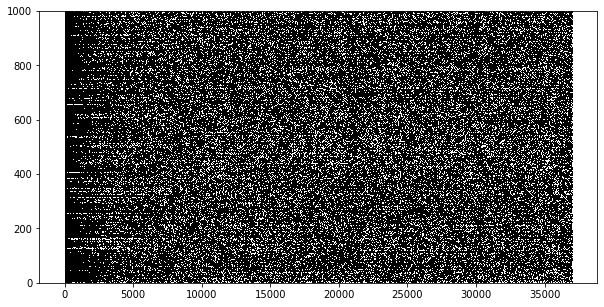

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(nnr.mon_spike_e.t/ms, nnr.mon_spike_e.i, ',k')
#plt.xlim([45800, 46200])
plt.ylim([0, 1000])

<Figure size 720x360 with 0 Axes>

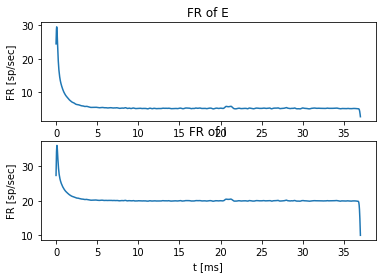

In [64]:
plt.figure(figsize=(10, 5))
plotter.plot_pop_fr(nnr)

In [65]:
type(nnr.mon_rate_e)

dotmap.DotMap

In [49]:
spikes = cs.get_spike_times_ps(nnr, n_ps=0, frac=0.02)

si, st = zip(*spikes)

TypeError: 'NoneType' object is not callable

(45500, 60500)

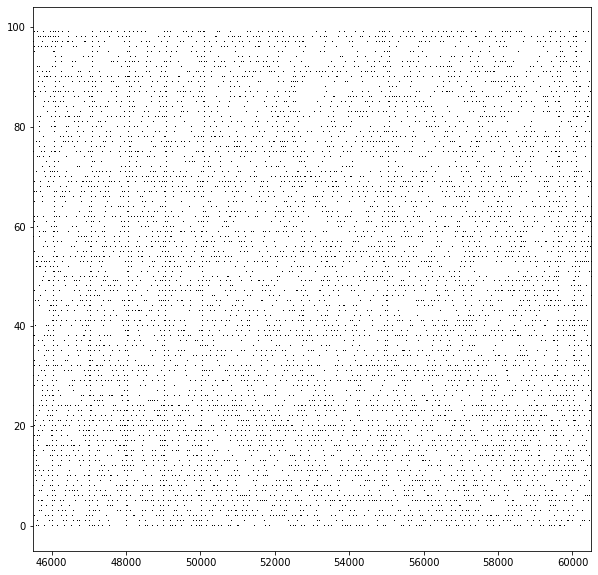

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(st/ms, si, ',k')
plt.xlim([45500, 60500])

In [20]:
g = asq.DotDict(nn.mon_rate_e.get_states())

In [52]:
mon_rate_e = asq.DotDict(nn.mon_rate_e.get_states()) if nn.mon_rate_e is not None else None

In [53]:
t = mon_rate_e['t']

In [58]:
np.median(np.diff(t/second))

9.999999999976694e-05

In [8]:
from dotmap import DotMap

In [9]:
g = DotMap(z)

In [14]:
z.keys()

dict_keys(['rate', 't', 'N'])

In [17]:
z['rate']

array([33. , 41.5, 33. , ...,  6. ,  7. ,  6.5]) * hertz

In [19]:
z.rate

AttributeError: 'dict' object has no attribute 'rate'

In [28]:
np.array(nn.mon_rate_e.rate)

array([33. , 41.5, 33. , ...,  6. ,  7. ,  6.5])

In [37]:
np.array(z['rate'])

array([33. , 41.5, 33. , ...,  6. ,  7. ,  6.5])

In [39]:
if nn.mon_rate_e is not None:
    print(1)

1


In [11]:
import copy

In [35]:
mr = copy.deepcopy(nn.mon_rate_e)

In [26]:
pickle.dumps(mr)

AttributeError: Can't pickle local object 'Synapses.__init__.<locals>.<lambda>'

In [14]:
import pickle

In [18]:
mr.source = None

In [43]:
for n in mr.variables._variables.keys():
    try:
        z = pickle.dumps(mr.variables._variables[n])
    except AttributeError as e:
        print ('Cannot pickle ' + n + ' ' + str(e))


Cannot pickle _spikespace Can't pickle local object 'Synapses.__init__.<locals>.<lambda>'
Cannot pickle rate Can't pickle local object 'Synapses.__init__.<locals>.<lambda>'
Cannot pickle t Can't pickle local object 'Synapses.__init__.<locals>.<lambda>'
Cannot pickle N Can't pickle local object 'Synapses.__init__.<locals>.<lambda>'
Cannot pickle _clock_t Can't pickle local object 'Synapses.__init__.<locals>.<lambda>'
Cannot pickle _clock_dt Can't pickle local object 'Synapses.__init__.<locals>.<lambda>'
Cannot pickle _clock_t_in_timesteps Can't pickle local object 'Synapses.__init__.<locals>.<lambda>'


In [44]:
mr.variables._variables['t']

<DynamicArrayVariable(dimensions=second,  dtype=<class 'numpy.float64'>, scalar=False, constant=False, read_only=True)>

In [38]:
mr.variables.__dir__()

['owner',
 'default_index',
 'device',
 '_variables',
 'indices',
 '__module__',
 '__doc__',
 '__init__',
 '__getitem__',
 '__len__',
 '__iter__',
 '_add_variable',
 'add_array',
 'add_arrays',
 'add_dynamic_array',
 'add_arange',
 'add_constant',
 'add_subexpression',
 'add_auxiliary_variable',
 'add_referred_subexpression',
 'add_reference',
 'add_references',
 'add_object',
 'create_clock_variables',
 '__dict__',
 '__weakref__',
 '__abstractmethods__',
 '_abc_registry',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '__slotnames__',
 '__slots__',
 'get',
 '__contains__',
 'keys',
 'items',
 'values',
 '__eq__',
 '__reversed__',
 '__hash__',
 '__subclasshook__',
 '__repr__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']